# Preprocessing

Import Modules

In [1]:
import os
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

n:\GUVI\AirDraw\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Set Global Random Seeds
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Load CSV Files

In [3]:
def load_csv(path):
    df = pd.read_csv(path)
    return df[["timestamp", "ax", "ay", "az", "gx", "gy", "gz"]]

Resample Each Recording to Fixed Length (T = 200)

In [4]:
def resample_to_fixed_length(df, T=200):
    features = df[["ax", "ay", "az", "gx", "gy", "gz"]]

    old_len = len(features)
    old_idx = np.linspace(0, old_len - 1, old_len)
    new_idx = np.linspace(0, old_len - 1, T)

    df_resampled = pd.DataFrame({
        col: np.interp(new_idx, old_idx, features[col].values)
        for col in features.columns
    })

    return df_resampled

Full Preprocessing for One File

In [5]:
def preprocess_file(path):
    df = load_csv(path)
    df_resampled = resample_to_fixed_length(df, T=200)
    return df_resampled.values  # shape: (200, 6)

Build Dataset (X, y)

In [6]:
def build_dataset(dataset_dir):
    X = []
    y = []

    for digit in range(10):
        digit_dir = os.path.join(dataset_dir, str(digit))

        for file in os.listdir(digit_dir):
            if file.endswith(".csv"):
                path = os.path.join(digit_dir, file)

                sample = preprocess_file(path)
                X.append(sample)
                y.append(digit)

    X = np.array(X)   # (N, 200, 6)
    y = np.array(y)   # (N,)

    return X, y

Create Dataset

In [7]:
x, y = build_dataset("dataset")

print(x.shape)  # (N, 200, 6)
print(y.shape)  # (N,)

(3000, 200, 6)
(3000,)


Train / Validation / Test Split (70 / 15 / 15)

In [8]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

Normalization

In [9]:
# Get shape
n_samples, n_timesteps, n_features = x_train.shape
n_samples, n_timesteps, n_features

(2100, 200, 6)

In [10]:
# Reshape to 2D
x_train_2d = x_train.reshape(-1, n_features)
x_val_2d   = x_val.reshape(-1, n_features)
x_test_2d  = x_test.reshape(-1, n_features)

In [11]:
# Fit and Transform training data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_2d)

In [12]:
# Save scaler for later use
os.makedirs("model", exist_ok=True)
joblib.dump(scaler, "model/standard_scaler.pkl")

['model/standard_scaler.pkl']

In [13]:
# Transform validation and test data
x_val_scaled   = scaler.transform(x_val_2d)
x_test_scaled  = scaler.transform(x_test_2d)

In [14]:
# Reshape back to 3D
x_train = x_train_scaled.reshape(n_samples, n_timesteps, n_features)
x_val   = x_val_scaled.reshape(x_val.shape[0], n_timesteps, n_features)
x_test  = x_test_scaled.reshape(x_test.shape[0], n_timesteps, n_features)

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((2100, 200, 6), (2100,), (450, 200, 6), (450,), (450, 200, 6), (450,))

In [16]:
x_train[100].shape

(200, 6)

# Model Develop

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Flatten,
    LSTM, GRU, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Small 1D CNN Baseline Model

In [18]:
def build_cnn_baseline(input_shape=(200, 6), num_classes=10):
    model = Sequential([
        Conv1D(
            filters=32,
            kernel_size=3,
            activation="relu",
            padding="same",
            input_shape=input_shape
        ),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(64, activation="relu"),

        Dense(num_classes, activation="softmax")
    ],
    name="CNN_Baseline_Model"
    )
    return model

Compile Baseline Model

In [19]:
cnn_baseline = build_cnn_baseline()

cnn_baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_baseline.summary()

n:\GUVI\AirDraw\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Baseline_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,122 (805.16 KB)

 Trainable params: 206,122 (805.16 KB)

 Non-trainable params: 0 (0.00 B)

Train Baseline Model

In [20]:
history_cnn_base = cnn_baseline.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7790 - loss: 0.7463 - val_accuracy: 0.9111 - val_loss: 0.3740
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9514 - loss: 0.1963 - val_accuracy: 0.9400 - val_loss: 0.2640
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9795 - loss: 0.0966 - val_accuracy: 0.9467 - val_loss: 0.2385
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9905 - loss: 0.0588 - val_accuracy: 0.9444 - val_loss: 0.2381
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9952 - loss: 0.0357 - val_accuracy: 0.9556 - val_loss: 0.2000
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0188 - val_accuracy: 0.9533 - val_loss: 0.1954
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0108 - val_accuracy: 0.9511 - val_loss: 0.2035
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0084 - val_accuracy: 0.9511 - val_loss:

Evaluate Baseline Model

In [21]:
test_loss, test_acc = cnn_baseline.evaluate(x_test, y_test)
print(f"Baseline CNN Test Accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9622 - loss: 0.1900 
Baseline CNN Test Accuracy: 0.9622


## Single LSTM Baseline

In [22]:
def build_lstm_baseline(input_shape=(200, 6), num_classes=10):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax")
    ],
    name="LSTM_Baseline_Model")
    return model

Compile LSTM Baseline Model

In [23]:
lstm_baseline = build_lstm_baseline()

lstm_baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lstm_baseline.summary()

n:\GUVI\AirDraw\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Baseline_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,986 (89.79 KB)

 Trainable params: 22,986 (89.79 KB)

 Non-trainable params: 0 (0.00 B)

Train LSTM Baseline Model

In [24]:
history_lstm_base = lstm_baseline.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3119 - loss: 1.9658 - val_accuracy: 0.4600 - val_loss: 1.5685
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5557 - loss: 1.3046 - val_accuracy: 0.5667 - val_loss: 1.2426
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6086 - loss: 1.0908 - val_accuracy: 0.6378 - val_loss: 0.9877
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6890 - loss: 0.8694 - val_accuracy: 0.7000 - val_loss: 0.9064
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7357 - loss: 0.7446 - val_accuracy: 0.8000 - val_loss: 0.6150
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7729 - loss: 0.6531 - val_accuracy: 0.7889 - val_loss: 0.6323
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7910 - loss: 0.5735 - val_accuracy: 0.7956 - val_loss: 0.5612
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7976 - loss: 0.5860 - val_accuracy: 0.7778 - v

Evaluate LSTM Baseline Model

In [25]:
test_loss, test_acc = lstm_baseline.evaluate(x_test, y_test)
print(f"Baseline LSTM Test Accuracy: {test_acc:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8156 - loss: 0.5185
Baseline LSTM Test Accuracy: 0.8156


## Model Improvement & Experiments

Implement CNN + LSTM Architecture

In [26]:
def build_cnn_lstm(input_shape=(200, 6), lstm_units=64):
    model = Sequential([
        Conv1D(64, 3, activation="relu", padding="same",
               input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling1D(2),

        LSTM(lstm_units),

        Dense(64, activation="relu"),
        Dropout(0.4),

        Dense(32, activation="relu"),
        Dropout(0.5),

        Dense(10, activation="softmax")
    ],
    name="CNN_LSTM_Improved"
    )
    return model

Data Augmentation

In [27]:
# Add Gaussian Noise
def add_noise(X, noise_std=0.01):
    noise = np.random.normal(0, noise_std, X.shape)
    return X + noise

# Usage (training only):
x_train_aug = add_noise(x_train, noise_std=0.02)

Compile and Training with Improvements

In [28]:
model = build_cnn_lstm(lstm_units=64)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "CNN_LSTM_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,666 (322.91 KB)

 Trainable params: 82,282 (321.41 KB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
callbacks = [EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
             ModelCheckpoint(
                 filepath="model/airdraw_model.keras",
                 monitor="val_accuracy",
                 save_best_only=True,
                 verbose=1
                 )]

history = model.fit(
    x_train_aug, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30


65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1891 - loss: 2.2065
Epoch 1: val_accuracy improved from None to 0.44444, saving model to model/airdraw_model.keras

Epoch 1: finished saving model to model/airdraw_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2524 - loss: 2.0643 - val_accuracy: 0.4444 - val_loss: 1.9878
Epoch 2/30
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4524 - loss: 1.5747
Epoch 2: val_accuracy improved from 0.44444 to 0.68889, saving model to model/airdraw_model.keras

Epoch 2: finished saving model to model/airdraw_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5143 - loss: 1.4248 - val_accuracy: 0.6889 - val_loss: 1.1273
Epoch 3/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6112 - loss: 1.0815
Epoch 3: val_accuracy improved from 0.68889 to 0.76222, saving model to model/airdraw_model.keras

Epoch 3: finished saving model to model/airdraw_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy

Plot Training vs Validation Curves

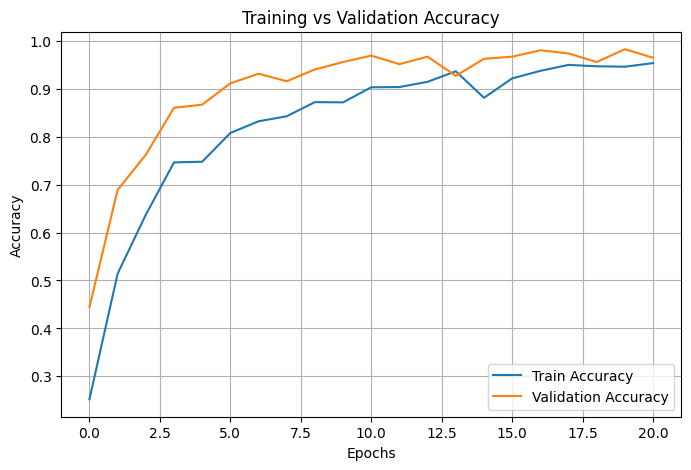

In [30]:
# 📈 Accuracy Curve
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)

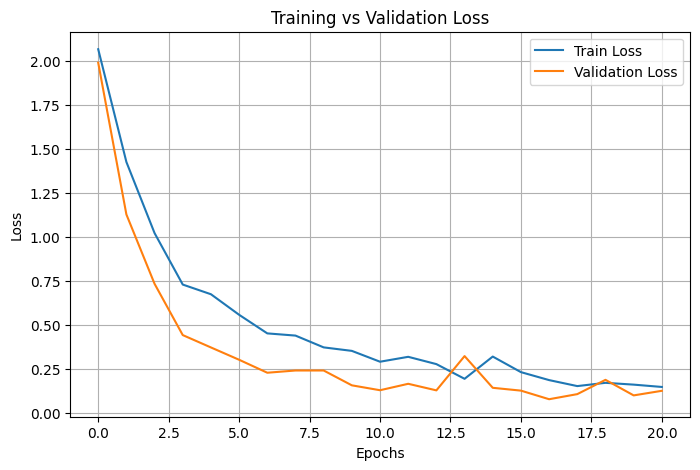

In [31]:
# 📉 Loss Curve
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

Confusion Matrix

In [32]:
# Get Predictions
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [33]:
# Compute Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[44,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 41,  2,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  0, 45,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0, 44,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 44,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  2,  0, 43,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 45,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 45,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 45,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 44]])

In [34]:
# Plot Confusion Matrix
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

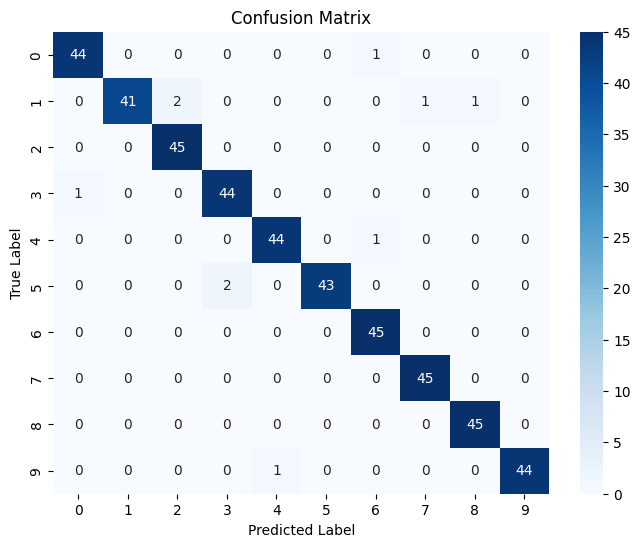

In [35]:
class_names = list(range(10))  # digits 0–9
plot_confusion_matrix(cm, class_names)

Classification Report

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       1.00      0.91      0.95        45
           2       0.96      1.00      0.98        45
           3       0.96      0.98      0.97        45
           4       0.98      0.98      0.98        45
           5       1.00      0.96      0.98        45
           6       0.96      1.00      0.98        45
           7       0.98      1.00      0.99        45
           8       0.98      1.00      0.99        45
           9       1.00      0.98      0.99        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

